# Bi-linear interaction model with group-by augmentations

## Prepare dataset for training

Following the same steps as in the training of the simple model (TODO link), we first load splitted dataset generated in [notebook](https://github.com/tinyclues/recsys-multi-atrribute-benchmark/blob/master/dataset_preprocessing/movielens%20with%20imdb.ipynb)

In [1]:
import os
import tensorflow as tf

from utils import DATASETS_ROOT_DIR

datasets = {}
for split_name in ['train', 'val', 'test']:
    path = os.path.join(DATASETS_ROOT_DIR, f'movielens_imdb/aggregated_{split_name}_dataset.tf')
    datasets[split_name] = tf.data.experimental.load(path, compression="GZIP")

2023-02-08 07:53:38.990742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-08 07:53:38.990798: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-08 07:53:41.485543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-08 07:53:41.485639: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN E

Then we parse features' names to obtain a list of offer features (that will be used to modelize film) and a list of user features (aggregated history up to chosen date)

In [2]:
from utils import AGG_PREFIX

all_columns = list(datasets['train'].element_spec.keys())
technical_columns = ['userId', 'date']
user_features = list(filter(lambda x: x.startswith(AGG_PREFIX), all_columns))
offer_features = list(filter(lambda x: x not in user_features + technical_columns, all_columns))

### Negative sampling

Generating negative examples and splitting dataset into batches in the same way as described in (TODO notebook link)

In [3]:
%%time

from functools import partial
from uuid import uuid4

from utils import merge_dims, generate_negatives_in_minibatches_and_rebatch

for key in ['val', 'test']:
    datasets[key] = generate_negatives_in_minibatches_and_rebatch(
        datasets[key].map(partial(merge_dims, 0, 1)),
        batch_size=63000, number_of_negatives=4, offer_features=offer_features,
        user_id_column='userId', date_column='date',
        deterministic=True, seed=1729).cache(f'/tmp/{uuid4()}.tf')
datasets['train'] = generate_negatives_in_minibatches_and_rebatch(
    datasets['train'].map(partial(merge_dims, 0, 1)),
    batch_size=17500, number_of_negatives=4, offer_features=offer_features,
    user_id_column='userId', date_column='date',
    deterministic=False)

CPU times: user 57.4 s, sys: 6.78 s, total: 1min 4s
Wall time: 1min 3s


## Define the model

First we need to get number of different modalities inputs can take from saved vectorizers (it will be used in embeddings layer definition):

In [4]:
from utils import load_inverse_lookups
inverse_lookups = load_inverse_lookups(os.path.join(DATASETS_ROOT_DIR, 'movielens_imdb/inverse_lookups.pickle'))

In [5]:
import re

vocabulary_sizes = {}

for feature in offer_features:
    vocabulary_sizes[feature] = inverse_lookups[feature].vocabulary_size()

for feature in user_features:
    for key in inverse_lookups:
        pattern = re.compile(r"{}(\w+)_{}".format(AGG_PREFIX, key))
        if pattern.match(feature):
            vocabulary_sizes[feature] = vocabulary_sizes[key]

### Layers definitions

To define a model with group-by augmentations we need to create some layers described in article (TODO link). In all following schemas we color weights that will be learned during training in red.

#### Generation of group-by augmentations

To get group-by augmentations we need first choose randomly some offer features we will use to get group by keys that will consist of AND and OR combinations of values from chosen features. It is implemented in `KeyGenerator` layer. Next once we get keys, we will group by and calculate mean and variance embeddings vectors for other features wrt to chosen keys. Finally, we will broadcast mean and variance vectors back to return to original batch size. Both calculation and broadcast are implemented in `GroupBy` layer.

![group-by augmentation generation](./resources/group_by_augmentation.png)

In [6]:
from layers import KeyGenerator, GroupBy

In [7]:
test_key_generator = KeyGenerator(number_of_offer_attributes=len(offer_features),
                                  average_number_of_attributes_in_key=2,
                                  name='test_key_generator')

In [8]:
# sampling randomly values for offer features
test_offer_features = tf.random.uniform((10, len(offer_features)), maxval=5, dtype=tf.int32)
test_offer_features

<tf.Tensor: shape=(10, 7), dtype=int32, numpy=
array([[2, 3, 3, 0, 2, 0, 0],
       [2, 3, 0, 2, 4, 4, 1],
       [4, 0, 4, 3, 2, 2, 3],
       [1, 1, 2, 0, 4, 2, 0],
       [2, 3, 0, 2, 3, 4, 0],
       [1, 2, 3, 4, 2, 0, 4],
       [2, 2, 1, 0, 2, 0, 2],
       [1, 0, 0, 1, 1, 2, 0],
       [0, 4, 0, 4, 4, 3, 0],
       [0, 3, 0, 3, 2, 1, 2]], dtype=int32)>

In [9]:
# key generator returns hashed keys for group by
test_keys = test_key_generator(test_offer_features)
test_keys

<tf.Tensor: shape=(10,), dtype=int64, numpy=
array([1507639157, 1155727721, 2035128454, 1507639157,  601718677,
       1285195157,  514680354,  208898033,   81570604, 1570251557])>

In [10]:
group_by = GroupBy(name='group_by')

In [11]:
# if we have some embeddings vectors
test_embeddings = tf.random.normal((10, 3))

In [12]:
# we can apply group-by operation for all features
test_mean, test_var = group_by(test_keys, test_embeddings)
test_mean.shape, test_var.shape

(TensorShape([10, 3]), TensorShape([10, 3]))

In [13]:
# or more direct example of group by
import numpy as np
group_by([0, 0, 1], np.eye(3))

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0.5, 0.5, 0. ],
        [0.5, 0.5, 0. ],
        [0. , 0. , 1. ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0.25, 0.25, 0.  ],
        [0.25, 0.25, 0.  ],
        [0.  , 0.  , 0.  ]], dtype=float32)>)

#### Compression of user features

For optimisation of calculation of interaction we want to reduce number of user features we use. For that we will generate meta features using a sequence of fully connected layers based on `tf.keras.layers.experimental.EinsumDense` layer.

![compression of user features](./resources/user_features_compression.png)

In [15]:
from layers import UserFeaturesCompressor
test_user_compressor = UserFeaturesCompressor(number_of_meta_features=2,
                                              dropout_rate=0.1,
                                              name='test_user_compressor')
test_user_compressor(tf.random.normal((10, 3, 7))).shape

TensorShape([10, 2, 7])

#### Compression of offer features and MaskNet

This is a key layer that will create some meta offer features and apply instance guided mask over embedding dimension. For meta features, the idea is similar to user side: we want to get smaller number of features before interaction, but here using information about variance we can completely deactivate some features, depending on offer we want to predict.

![compression of offer features](./resources/offer_features_compression.png)

In [17]:
from layers import OfferFeaturesCompressor
test_offer_compressor = OfferFeaturesCompressor(number_of_meta_features=2,
                                                dropout_rate=0.1,
                                                name='test_offer_compressor')
test_offer_compressor([tf.random.normal((10, 3, 7)), tf.random.normal((10, 3, 7))]).shape

TensorShape([10, 2, 7])

In [18]:
from layers import MaskNet
test_mask = MaskNet(number_of_meta_features=2, dropout_rate=0.1)
test_mask([tf.random.normal((10, 3, 7)), tf.random.normal((10, 3, 7))]).shape

TensorShape([10, 2, 7])

#### Bi-linear feature-wise interaction

Last step is a calculation of interaction using bi-linear kernel for each pair of meta features from user and from offer:

![bi-linear feature wise interaction](./resources/bi_linear_interaction.png)

In [19]:
from layers import BiLinearInteraction
test_interaction = BiLinearInteraction(name='test_interaction')
test_interaction([tf.random.normal((10, 4, 7)), tf.random.normal((10, 3, 5))]).shape

TensorShape([10, 12])

### Model architecture

Now we can assemble all these layers into final model. Note that offer compression weights and interaction kernels are shared between different augmentations we generate.

![model](./resources/bi_linear_augmentation_model.png)

### Model parameters

TODO describe tuning choices

In [20]:
EMBEDDING_DIM = 30
L1_COEFF = 1e-6
DROPOUT = 0.05
NB_AUGMENTATIONS = 3
AVERAGE_NUMBER_OF_FEATURES_IN_AUGMENTATION = 2
USER_META_FEATURES = 5
OFFER_META_FEATURES = 3

def REGULARIZER():
    return {'class_name': 'L1L2', 'config': {'l1': L1_COEFF, 'l2': 0.}}

def OUTPUT_DNN():
    return tf.keras.Sequential([
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(20, activation='gelu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(20, activation='gelu'),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(1),
    ])

EPOCHS = 5

LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
AUC_METRIC = tf.keras.metrics.AUC(from_logits=True)

import tensorflow_addons as tfa
OPTIMIZER = tfa.optimizers.AdamW(weight_decay=1e-8, learning_rate=0.002)

### Embeddings

We will define embeddings with the same `WeightedEmbeddings` layer described in (TODO notebook link) with one addition:
* for offer features when aggregating a list of embedding vectors, we will also calculate variance and not only mean vector

It is easy to do in the same sparse-dense matrix multiplication operation as mean calculation (we get second moment and then calculate variance from it).

In [23]:
from layers import get_input_layer, WeightedEmbeddings
from utils import WEIGHT_SUFFIX

inputs = {}
embedded_user_features, embedded_offer_features, variance_offer_features = {}, {}, {}
for feature in user_features:
    inputs[feature] = get_input_layer(feature)
    emb_layer = WeightedEmbeddings(vocabulary_sizes[feature],
                                   EMBEDDING_DIM, name=f'{feature}_embedding',
                                   embeddings_regularizer=REGULARIZER())
    embedded_user_features[feature] = emb_layer(inputs[feature])
for feature in offer_features:
    # for offer features we need weights:
    # with dummy weights during training, and the ones used for a feature's averaging at inference time
    inputs[f'{feature}_weight'] = get_input_layer(f'{feature}_weight', tf.float32)
    inputs[feature] = get_input_layer(feature)
    emb_layer = WeightedEmbeddings(vocabulary_sizes[feature],
                                   EMBEDDING_DIM, name=f'{feature}_embedding',
                                   embeddings_regularizer=REGULARIZER(),
                                   calculate_variance=True)
    embedded_offer_features[feature], variance_offer_features[feature] = emb_layer(inputs[feature],
                                                                                   inputs.get(f'{feature}_weight'))

### Combining everything into model

Now we can define described model architecture on the top of embeddings.

In [24]:
user_stacked = tf.stack(list(embedded_user_features.values()), axis=1)
offer_stacked = tf.stack(list(embedded_offer_features.values()), axis=1)
offer_variance = tf.stack(list(variance_offer_features.values()), axis=1)
stacked_raw_offer_attrs = tf.stack([tf.cast(inp.values, tf.int32) for feature, inp in inputs.items()
                                    if feature in offer_features], axis=1)

In [25]:
stacked_raw_offer_attrs

<KerasTensor: shape=(None, 7) dtype=int32 (created by layer 'tf.stack_3')>

In [26]:
key_generator = KeyGenerator(number_of_offer_attributes=len(offer_features),
                             average_number_of_attributes_in_key=AVERAGE_NUMBER_OF_FEATURES_IN_AUGMENTATION,
                             name='grp_key_generator')

user_compressed = UserFeaturesCompressor(USER_META_FEATURES, DROPOUT,
                                         name='user_compressor')(user_stacked)
offer_features_compressor = OfferFeaturesCompressor(OFFER_META_FEATURES, DROPOUT, name='offer_compressor')
mask_net = MaskNet(OFFER_META_FEATURES, DROPOUT, name='mask_generation')
apply_mask = tf.keras.layers.Multiply(name='apply_mask')
bi_linear_interaction = BiLinearInteraction(initializer='random_normal', regularizer=REGULARIZER(),
                                            name='interaction')
output_dnn = OUTPUT_DNN()

augmentation_predictions = []
for i in range(NB_AUGMENTATIONS):
    group_by_key = key_generator(stacked_raw_offer_attrs)
    mean_offer_emb, variance_offer_emb = group_by(group_by_key, offer_stacked)
    compressed_offer_embeddings = offer_features_compressor([mean_offer_emb, variance_offer_emb])
    mask = mask_net([mean_offer_emb, variance_offer_emb])
    masked_offer_embeddings = apply_mask([compressed_offer_embeddings, mask])
    _output = output_dnn(bi_linear_interaction([user_compressed, masked_offer_embeddings]))
    augmentation_predictions.append(_output)
output = tf.concat(augmentation_predictions, axis=1)

In [29]:
# to broadcast true y onto augmented predictions we wrap loss and metric into utility classes
from utils import BroadcastLoss, BroadcastMetric

model = tf.keras.Model(inputs, output, name='bi_linear_with_augmentations')
model.compile(optimizer=OPTIMIZER, loss=BroadcastLoss(LOSS), metrics=[BroadcastMetric(AUC_METRIC)])

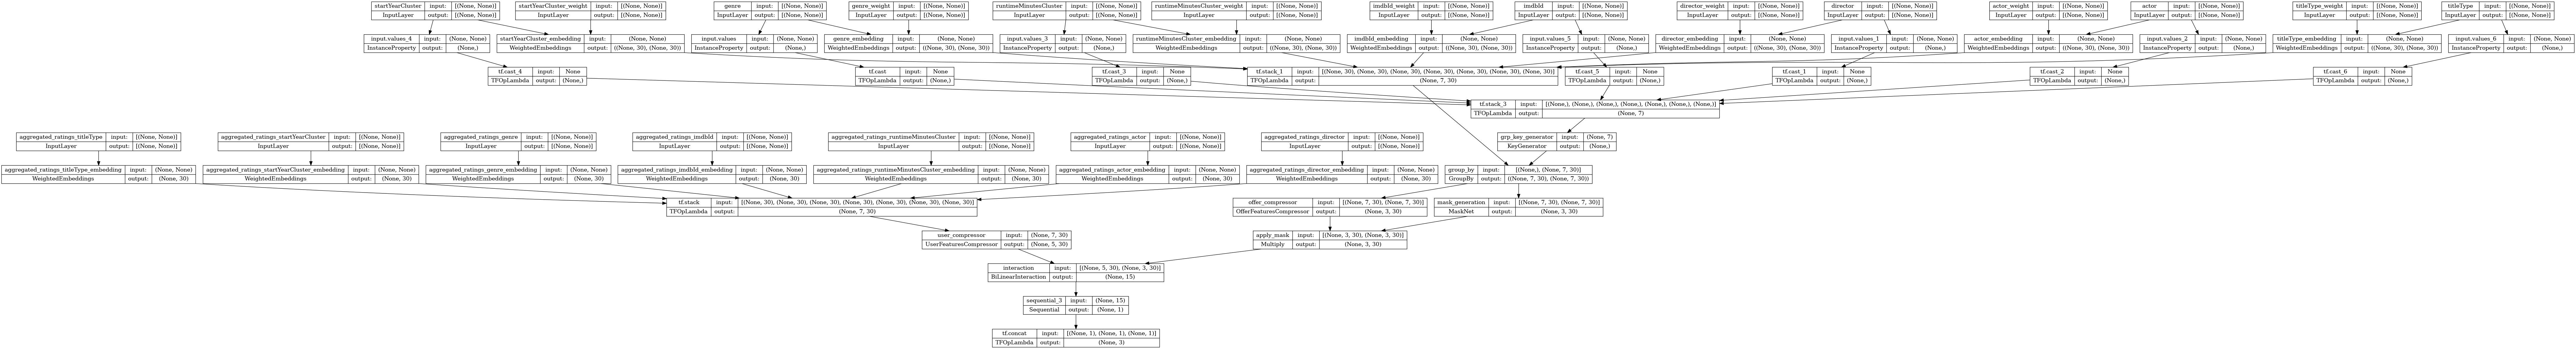

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='models/bi_linear_with_augmentations.png')

### Training

In [31]:
model.fit(datasets['train'], epochs=1, validation_data=datasets['val'])

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['date', 'userId'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/bi_linear_with_augmentations/group_by/moments_2/Reshape_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/bi_linear_with_augmentations/group_by/moments_2/Reshape_3:0", shape=(None, 7, 30), dtype=float32), dense_shape=Tensor("gradient_tape/bi_linear_with_augmentations/group_by/moments_2/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:446

   2428/Unknown - 5484s 2s/step - loss: 0.4939 - auc: 0.5974

2023-02-08 09:34:30.483517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2086: UserWarning: Metric BroadcastMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2428/2428 [==============================] - 5601s 2s/step - loss: 0.4939 - auc: 0.5974 - val_loss: 0.4986 - val_auc: 0.5912


2023-02-08 09:36:20.306308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Look at offer features compressor

In [32]:
model.get_layer('offer_compressor')

## Prepare dataset for inference with averaging

In [ ]:
OFFER_FEATURE_TO_SCORE = 'genre'

In [ ]:
raw_test_ds = tf.data.experimental.load(os.path.join(DATASETS_ROOT_DIR, 'movielens_imdb/aggregated_test_dataset.tf'),
                                        compression="GZIP")

In [ ]:
from utils import gather_structure


@tf.function(input_signature=(tf.TensorSpec(shape=(None,), dtype=tf.int32),))
def row_unique_values(x):
    return tf.unique(x)[0]


@tf.function(input_signature=(tf.TensorSpec(shape=(None,), dtype=tf.int32),))
def row_unique_values_cut(x, n_cut=1000):
    val, _, count = tf.unique_with_counts(x)
    # TODO on cumsum ? 0.95
    biggest_idx = tf.argsort(count)[-n_cut:]
    return tf.gather(val, biggest_idx), tf.cast(tf.linalg.normalize(tf.gather(count, biggest_idx), ord=1)[0], tf.float32)


def prepare_inference_dataset(ds, raw_ds, key, item_features):
    tf_ds = next(iter(raw_ds))
    length = tf_ds[key].values.shape[0]
    n_keys = tf.reduce_max(tf_ds[key]) + 1
    group_idx = tf.ragged.stack_dynamic_partitions(tf.range(length), tf_ds[key].values, n_keys)
    group_idx = tf.gather(tf_ds[key].value_rowids(), group_idx)
    
    aggregated_target = {}
    for ff in item_features:
        if ff == key:
            aggregated_target[ff] = tf.RaggedTensor.from_uniform_row_length(tf.range(n_keys), 1).with_row_splits_dtype(tf.int32)
            aggregated_target[ff + '_weight'] = aggregated_target[ff].with_values(tf.ones(n_keys, dtype=tf.float32)).with_row_splits_dtype(tf.int32)
        else:
            aggregated_target[ff], aggregated_target[ff + '_weight'] = \
                tf.map_fn(row_unique_values_cut,
                          tf.gather(tf_ds[ff], group_idx).merge_dims(1, 2),
                          fn_output_signature=(tf.RaggedTensorSpec(shape=[None], dtype=tf.int32),
                                               tf.RaggedTensorSpec(shape=[None], dtype=tf.float32)))
            aggregated_target[ff] = aggregated_target[ff].with_row_splits_dtype(tf.int32)
            aggregated_target[ff + '_weight'] = aggregated_target[ff + '_weight'].with_row_splits_dtype(tf.int32)
    
    def batch_map(batch, y):
        key_values = batch[key].values
        return {**batch, **gather_structure(aggregated_target, key_values)}, y
    
    return ds.map(batch_map)

In [ ]:
%%time
test_ds = prepare_inference_dataset(datasets['test'], raw_test_ds, OFFER_FEATURE_TO_SCORE, item_features)

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

def evaluate_model(model, ds, inverse_lookups, key):
    y = tf.zeros([0], dtype=tf.int32)
    y_pred = tf.zeros([0, 1], dtype=tf.float32)
    groups = tf.zeros([0], dtype=tf.int32)
    for batch, y_batch in ds:
        y_pred = tf.concat([y_pred, model(batch)], axis=0)
        y = tf.concat([y, y_batch], axis=0)
        groups = tf.concat([groups, batch[key].values], axis=0)
    res = pd.DataFrame({'true': y, 'pred': tf.squeeze(y_pred), 'group_idx': groups})
    res = res\
        .groupby('group_idx')\
        .apply(lambda group: roc_auc_score(group.true, group.pred))\
        .to_frame('auc')
    res['name'] = pd.Series(inverse_lookups[key].get_vocabulary())
    group_counts = tf.unique_with_counts(groups)
    res['counts'] = pd.Series(group_counts.count, group_counts.y)
    return res

In [ ]:
%%time
scores = evaluate_model(model, test_ds, inverse_lookups, OFFER_FEATURE_TO_SCORE)

In [ ]:
scores